# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [84]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [85]:
# Read the Mapbox API key
load_dotenv("MY_Keys.env")
map_box_api = os.getenv("MAPBOX_API_KEY")
px.set_mapbox_access_token(map_box_api)

In [86]:
map_box_api

'pk.eyJ1IjoicHlhZ2gxMSIsImEiOiJja250bXl3dW4wM3U5Mm9xcWFreWxjY2FnIn0.Y9jjk92mGuiiSK2s68Pjqg'

# Import Data

In [87]:
# Import the necessary CSVs to Pandas DataFrames
# YOUR CODE HERE!
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path)


In [88]:
sfo_data.head()

,neighborhood,sale_price_sqr_foot,housing_units,gross_rent
year,,,,
2010,Alamo Square,291.182945,372560,1239
2010,Anza Vista,267.932583,372560,1239
2010,Bayview,170.098665,372560,1239
2010,Buena Vista Park,347.394919,372560,1239
2010,Central Richmond,319.027623,372560,1239


In [89]:
df_neighborhood_locations.head()

,Neighborhood,Lat,Lon
0,Alamo Square,37.791012,-122.402100
1,Anza Vista,37.779598,-122.443451
2,Bayview,37.734670,-122.401060
3,Bayview Heights,37.728740,-122.410980
4,Bernal Heights,37.728630,-122.443050


- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [105]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    
    housing_unit= sfo_data.groupby('year').mean()
    housing_units = housing_unit.drop(['sale_price_sqr_foot', 'gross_rent'], axis = 1)
    
    #housing_units_fig = plt.figure()
    # housing_units_per_year_plot = plt.figure()
    min = housing_units.min()['housing_units']
    max = housing_units.max()['housing_units']
    
    housing_units_fig = plt.figure()
    housing_units_per_year_plot = housing_units.plot.bar(ylim =(min-2000, max+2000),title="Average Housing Units/Year in San Francisco", figsize=(12,8))
    
    plt.close(housing_units_fig)

    #plt.close(housing_units_per_year_plot)
    
    
    # return pn.pane.Matplotlib(housing_units_per_year_plot)
    return pn.pane.Matplotlib(housing_units_fig)


def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    
    avg_gross_rent = pd.DataFrame(sfo_data.groupby(['year']).mean()['gross_rent'])
    
    avg_gross_rent_plot = avg_gross_rent.plot.line(title="Average Gross Rent by Year in San Francisco", figsize=(12,8), color='red')

    return avg_gross_rent_plot

def average_sales_price():
    """Average Sales Price Per Year."""
    
    avg_price_sqft = pd.DataFrame(sfo_data.groupby(['year']).mean()['sale_price_sqr_foot'])
    average_sales_price_plot = avg_price_sqft.plot.line(title="Average Price per SqFt by year in San Francisco",figsize=(12,8),color='purple')
    
    return average_sales_price_plot 

def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    
    mean_values = sfo_data.groupby([sfo_data.index, "neighborhood"]).mean()
    mean_values.reset_index(inplace=True)
    # mean_values.rename(columns={"level_0": "year"}, inplace=True)
    
    average_price_by_neighborhood_plot = mean_values.hvplot.line(
    x="year",
    y="sale_price_sqr_foot",
    xlabel= "Year",
    ylabel="Average Sale Price per Square Foot",
    groupby="neighborhood",
)

    return average_price_by_neighborhood_plot

def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""

    ten_most_expensive_df = sfo_data.groupby("neighborhood").mean()
    ten_most_expensive_df = ten_most_expensive_df.sort_values("sale_price_sqr_foot", ascending=False).head(10)
    ten_most_expensive_df = ten_most_expensive_df.reset_index()
    
    top_most_expensive_neighborhoods_plot = ten_most_expensive_df.hvplot.bar(
    x="neighborhood",
    y="sale_price_sqr_foot",
    title="Top 10 Most Expensive Neighborhoods in SFO",
    xlabel="Neighborhood",
    ylabel="Average Sale Price per Square Foot",
    height=400,
    rot=45
    )

    return top_most_expensive_neighborhoods_plot

def most_expensive_neighborhoods_rent_sales():
    """Comparison of Rent and Sales Prices of Most Expensive Neighborhoods."""   
    
    most_expensive_neighborhoods_rent_sales_plot = sfo_data.hvplot.bar(
    x="year",
    y=["gross_rent", "sale_price_sqr_foot"],
    title="Top 10 Most Expensive Neighborhoods in SFO",
    xlabel="Neighborhood",
    ylabel="Num Housing Units",
    height=400,
    rot=45,
    groupby="neighborhood"
)

    
    return most_expensive_neighborhoods_rent_sales_plot

# def parallel_coordinates():  commented out due to optional
   # """Parallel Coordinates Plot."""

    # YOUR CODE HERE!



# def parallel_categories(): commented out due to optional
 #   """Parallel Categories Plot."""
    
    # YOUR CODE HERE!



def neighborhood_map():
    """Neighborhood Map."""

    mean_neighborhoods = sfo_data.groupby("neighborhood").mean()
    mean_neighborhoods = mean_neighborhoods.reset_index()
    
    ten_most_expensive_df = sfo_data.groupby("neighborhood").mean()
    ten_most_expensive_df = ten_most_expensive_df.sort_values("sale_price_sqr_foot", ascending=False).head(10)
    ten_most_expensive_df = ten_most_expensive_df.reset_index()

    values_and_locations_df = pd.concat([
    df_neighborhood_locations,
    mean_neighborhoods['sale_price_sqr_foot'],
    mean_neighborhoods['housing_units'],
    mean_neighborhoods['gross_rent']
    ], axis=1).dropna()

    values_and_locations_df.head()
    
    px.set_mapbox_access_token(map_box_api)
    
    map = px.scatter_mapbox(
    values_and_locations_df,
    lat="Lat",
    lon="Lon",
    size="sale_price_sqr_foot",
    color="gross_rent",
    color_continuous_scale=px.colors.cyclical.IceFire,
    size_max=15,
    zoom=11,
    width=1100,
    hover_name="Neighborhood",
    title="Avg Sale price per Square Foot and Gross Rent in San Francisco",
    )
    

    plotly_panel = pn.pane.Plotly(map)
    plotly_panel._updates = True
    return plotly_panel

# def sunburst(): commented out due to optional
  #  """Sunburst Plot."""
    
    # YOUR CODE HERE!


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

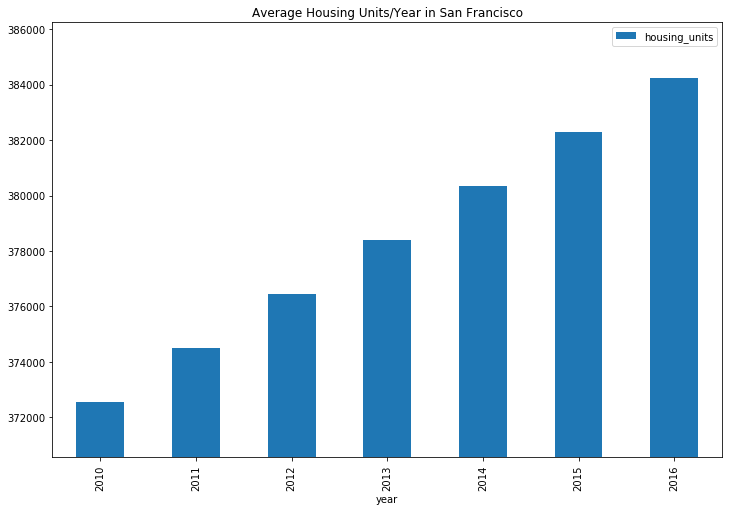

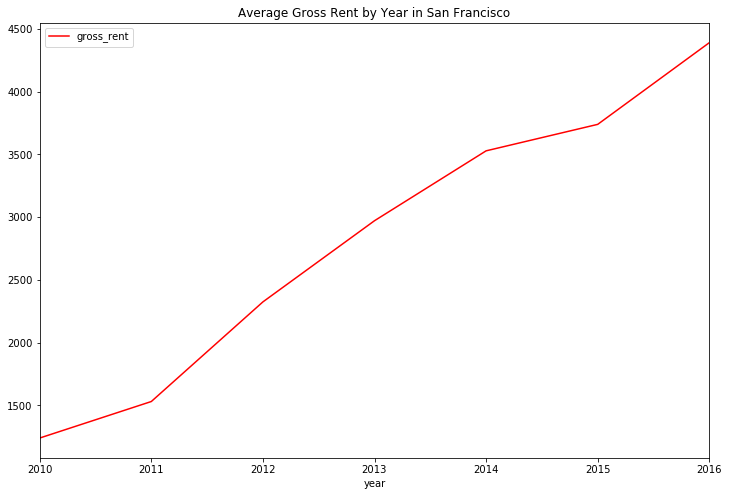

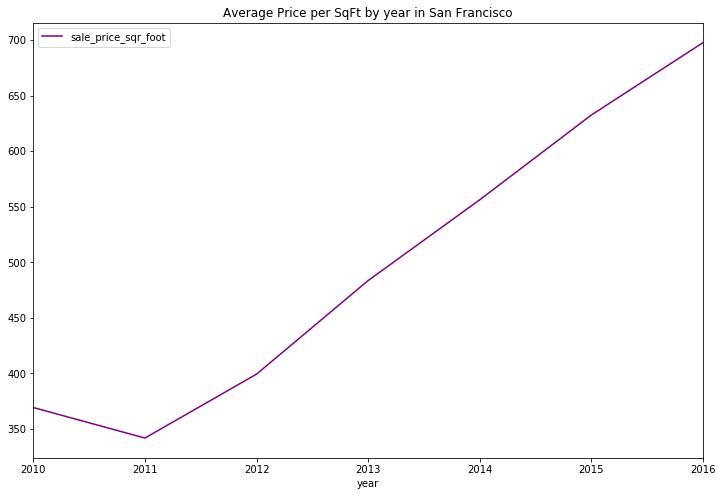

In [113]:
# Create a Title for the Dashboard
# YOUR CODE HERE!
title = pn.pane.Markdown(
    """
# Real Estate Analysis of San Francisco from 2010 to 2016
""",
    width=800,
)
welcome = pn.pane.Markdown(
    """
This dashboard presents a visual analysis of the San Francisco real estate market.
"""
)

# Create a tab layout for the dashboard
# YOUR CODE HERE!

tabs = pn.Tabs(
    ("Welcome", pn.Column(welcome, neighborhood_map())),
    ("Yearly Market Analysis", pn.Row(housing_units_per_year(), average_gross_rent(), average_sales_price())),
    ("Neighborhood Analysis", pn.Column(average_price_by_neighborhood(), top_most_expensive_neighborhoods(), most_expensive_neighborhoods_rent_sales())),
)
panel = pn.Column(pn.Row(title), tabs, width=9000)
# Create the dashboard
# YOUR CODE HERE!

## Serve the Panel Dashboard

Column(width=9000)
    [0] Row
        [0] Markdown(str, width=800)
    [1] Tabs
        [0] Column
            [0] Markdown(str)
            [1] Plotly(Figure)
        [1] Row
            [0] Matplotlib(Figure)
            [1] Str(AxesSubplot)
            [2] Str(AxesSubplot)
        [2] Column
            [0] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                    [1] VSpacer()
            [1] HoloViews(Bars)
            [2] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                    [1] VSpacer()
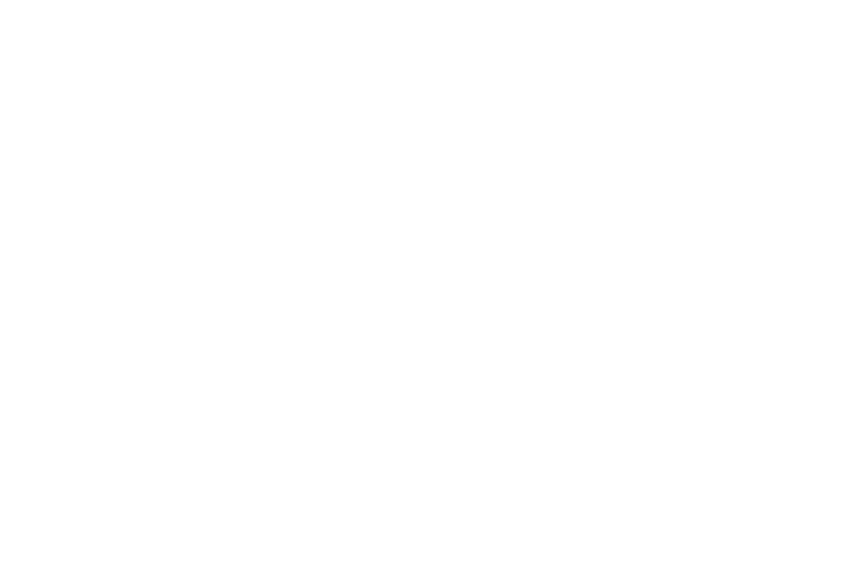

In [114]:
# Serve the# dashboard
# YOUR CODE HERE!
panel.servable()

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

Matplotlib(Figure)
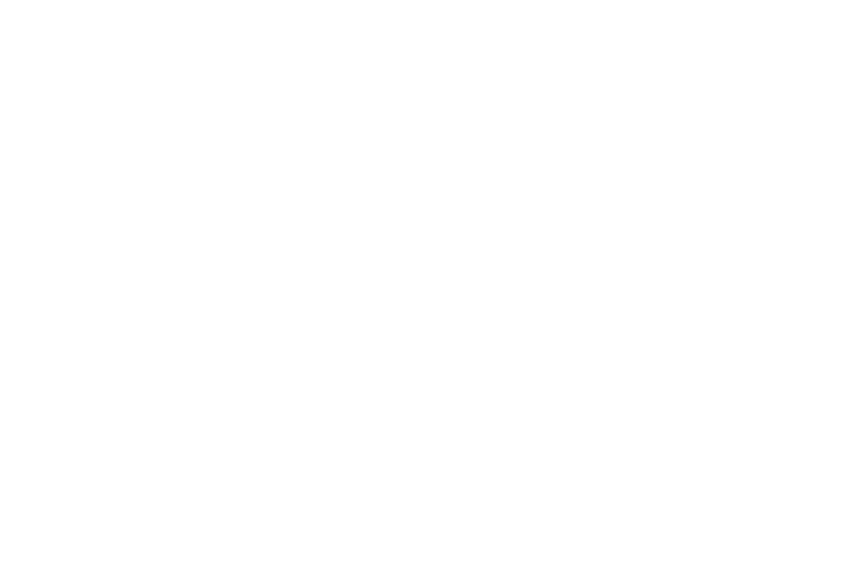

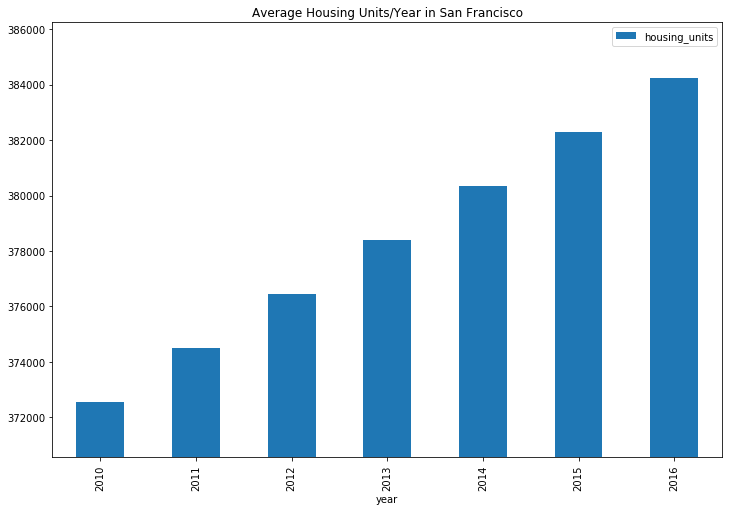

In [80]:
housing_units_per_year()

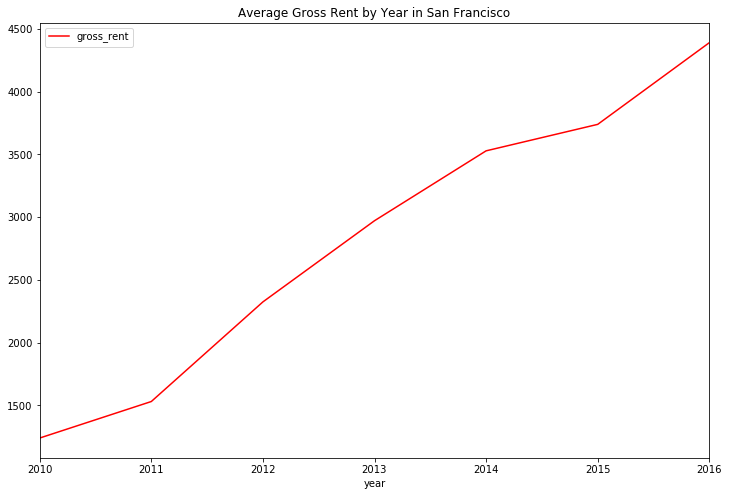

In [66]:
average_gross_rent()

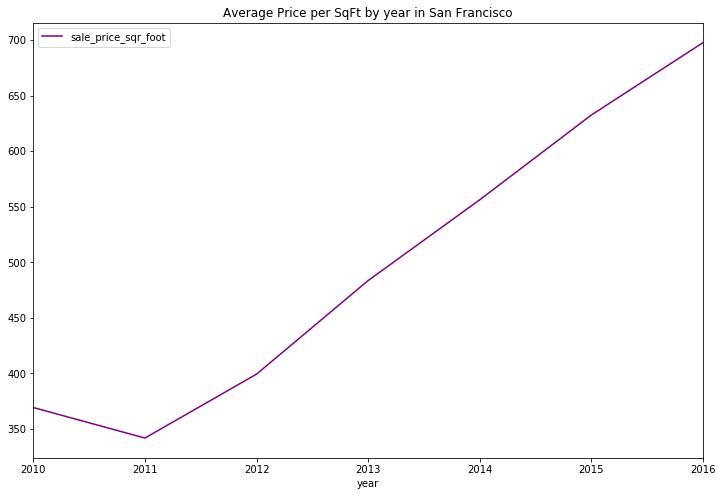

In [67]:
average_sales_price()

In [68]:
average_price_by_neighborhood()

:DynamicMap   [neighborhood]
   :Curve   [year]   (sale_price_sqr_foot)

In [49]:
top_most_expensive_neighborhoods()

:Bars   [neighborhood]   (sale_price_sqr_foot)

In [50]:
most_expensive_neighborhoods_rent_sales()

:DynamicMap   [neighborhood]
   :Bars   [year,Variable]   (value)

In [41]:
neighborhood_map().show()

Launching server at http://localhost:62411


In [ ]:
# parallel_categories()

In [ ]:
# parallel_coordinates()

In [ ]:
# sunburst()